In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
specgrams = []
try:
    with open('spectrograms.obj', 'rb') as specgram_file:
        specgrams = pickle.load(specgram_file)

except Exception as e:
    print('ERROR: ' + str(e))
    
print(len(specgrams))

79


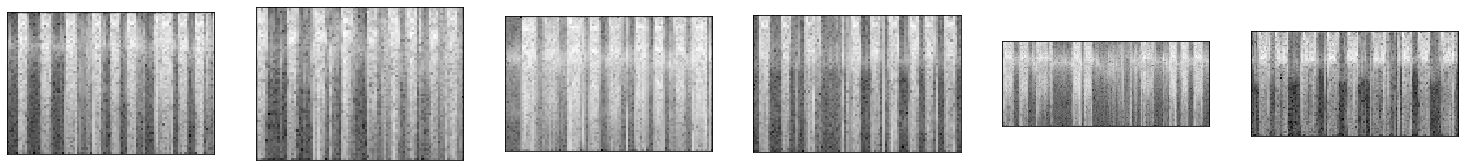

In [4]:
n=6
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(specgrams[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [5]:
reshape = [specgram[:,:80].reshape(specgram[:,:80].shape[0]*specgram[:,:80].shape[1])[:5200] for specgram in specgrams if 80 <= specgram.shape[1] <= 100]

X_train, X_test = train_test_split(reshape, test_size=0.25, shuffle=False)
print(X_train[0].shape)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

(5200,)
Training samples: 33
Test samples: 12


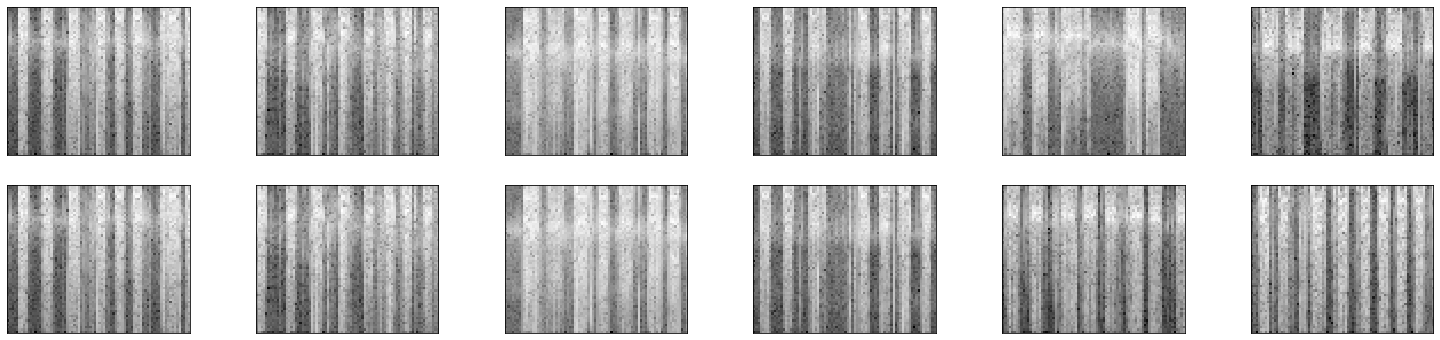

In [6]:
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(specgrams[i][:,:80], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+n+1)
    columns = reshape[i].shape[0]
    reconstruct = reshape[i].reshape(65, int(columns/65))
    plt.imshow(reconstruct, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Autoencoder Model

In [7]:
input_img = Input(X_train[0].shape)

# encoder
code = Dense(1280, activation='relu')(input_img)
code = Dense(320, activation='relu')(code)
code = Dense(80, activation='relu')(code)

# decoder
x_hat = Dense(320, activation='relu')(code)
x_hat = Dense(1280, activation='relu')(x_hat)
x_hat = Dense(5200, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              6657280   
_________________________________________________________________
dense_2 (Dense)              (None, 320)               409920    
_________________________________________________________________
dense_3 (Dense)              (None, 80)                25680     
_________________________________________________________________
dense_4 (Dense)              (None, 320)               25920     
_________________________________________________________________
dense_5 (Dense)              (None, 1280)              410880    
_________________________________________________________________
dense_6 (Dense)              (None, 5200)              6661200   
Total para

In [8]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

In [9]:
# tamanho do batch por iteracao
batch_size = 1

# número de épocas 
epochs = 8

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test], [X_test]))

Train on 33 samples, validate on 12 samples
Epoch 1/8
33/33 [==============================] - 5s 160ms/step - loss: 0.6905 - val_loss: 0.6854
Epoch 2/8
33/33 [==============================] - 5s 138ms/step - loss: 0.6612 - val_loss: 0.6559
Epoch 3/8
33/33 [==============================] - 4s 136ms/step - loss: 0.6397 - val_loss: 0.6519
Epoch 4/8
33/33 [==============================] - 4s 136ms/step - loss: 0.6389 - val_loss: 0.6558
Epoch 5/8
33/33 [==============================] - 4s 135ms/step - loss: 0.6383 - val_loss: 0.6526
Epoch 6/8
33/33 [==============================] - 4s 136ms/step - loss: 0.6383 - val_loss: 0.6556
Epoch 7/8
33/33 [==============================] - 5s 137ms/step - loss: 0.6383 - val_loss: 0.6538
Epoch 8/8
33/33 [==============================] - 5s 138ms/step - loss: 0.6380 - val_loss: 0.6534


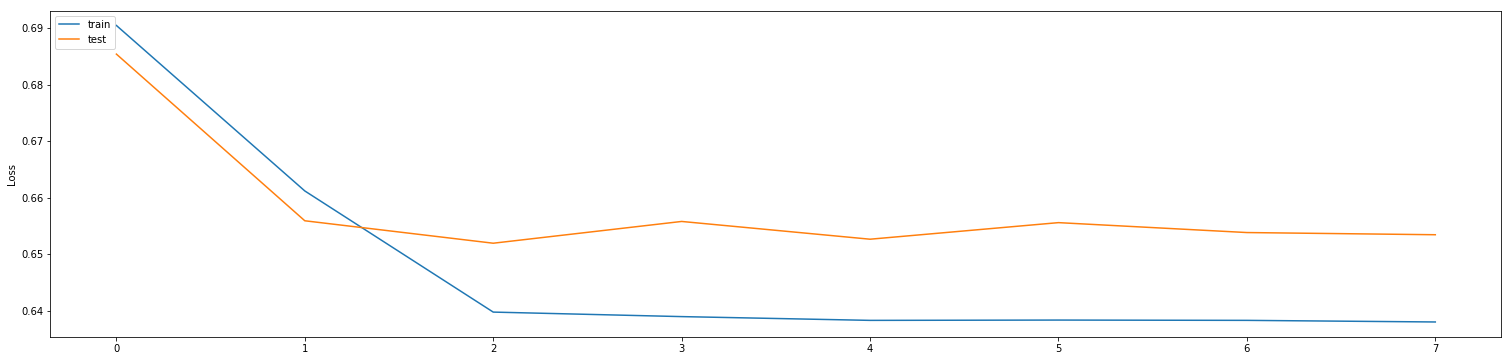

In [10]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
decoded_imgs = autoencoder.predict([X_test])

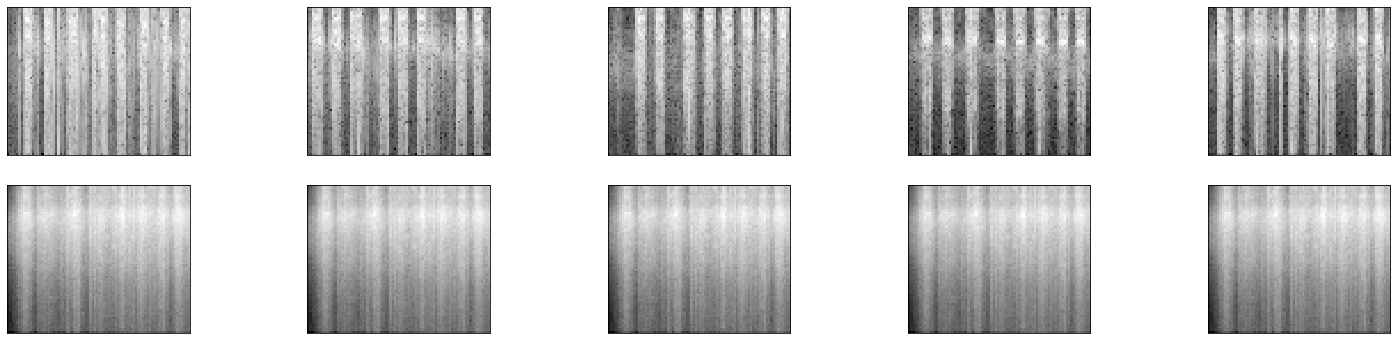

In [12]:
n=5
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    columns = X_test[i].shape[0]
    plt.imshow(X_test[i].reshape(65, int(columns/65)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    columns = X_test[i].shape[0]
    plt.imshow(decoded_imgs[i].reshape(65, int(columns/65)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()